In [5]:
%load_ext autoreload
%autoreload 2

import os, sys
mypath = os.getcwd() + '/ItemBandits'
if mypath not in sys.path:
    sys.path.append(mypath)
    
mypath = os.getcwd() + '/ItemBandits/abstract'
if mypath not in sys.path:
    sys.path.append(mypath)

import pandas as pd
import numpy as np
import multiprocessing as mp

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
df = pd.read_csv('data/genres.csv')
print(len(df))
# df['tag'] = df['tag'].str.lower()
# df = df[df.groupby('tag').userId.transform(len) > 0]
# print(len(df))

22084


In [48]:
df2 = df[['movieId','tag']]
matrix = df2.to_numpy()
movies = np.unique(matrix[:,0])
tags,counts = np.unique(matrix[:,1],return_counts=True)

print(len(movies))

occurrences = pd.DataFrame(0,index=movies,columns=tags)
print(occurrences.memory_usage().sum()/1024,'Mb')

for index,row in df2.iterrows():
    occurrences.at[row['movieId'],row['tag']] += 1
    
tag_counts = dict(zip(tags,counts))

occurrences.head()

9742
1598.296875 Mb


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
def tf(tag,item):
    f = occurrences.at[item,tag]
    if f:
        return 1 + np.log2(f)
    else:
        return 0

def idf(tag):
    total = np.sum(list(tag_counts.values()))
    count = tag_counts[tag]
    return np.log2(total/count)

def context(item):
    cont = np.zeros(len(tags))
    for i,tag in enumerate(tags):
        cont[i] = tf(tag,item)*idf(tag)
    return cont

In [47]:
cont = Context()
cont.read_csv('data/tags.csv')
print(np.sum(cont.context(1)))

31.218068950811855


In [16]:
df = pd.read_csv('data/movies.csv')
df_genres = df[['movieId','genres']]
df_genres.head()
df_cols = pd.DataFrame(columns=['movieId','tag'])

for _,row in df_genres.iterrows():
    movieId = row['movieId']
    genres = row['genres'].split('|')
    for genre in genres:
        dic = {'movieId':movieId,'tag':genre}
        df_cols = df_cols.append(dic,ignore_index=True)
        
df_cols.to_csv('data/genres.csv')

In [13]:
from LinUCB import LinUCB

band = LinUCB(alpha=0.1)
band.read_csv('data/ratings.csv')
band.read_tags_csv('data/genres.csv')

band.add_itemArms()
band.run_epoch(100000,trainSize=0)

[9302.39433527    0.            0.        ]


[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

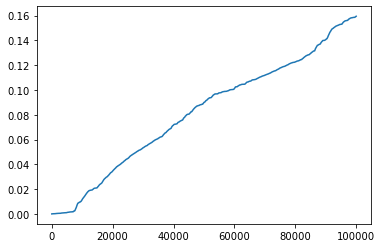

In [14]:
band.plot_results()

  0%|          | 0/100000.0 [00:00<?, ?it/s]

[10652.41409755     0.             0.        ]


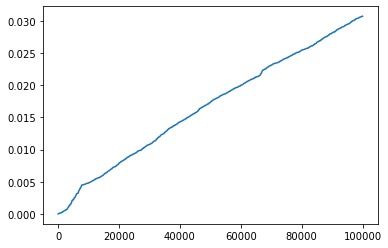

In [8]:
from DynUCB import DynUCB

band = DynUCB()
band.read_csv('data/ratings.csv')
band.read_tags_csv('data/genres.csv')

band.add_itemArms()
ep = band.run_epoch(1e5,trainSize = 0)

band.plot_results()

In [3]:
from CLUB import CLUB

def ret_recall(alpha):
    band = CLUB(2.5,alpha)
    band.read_csv('data/ratings.csv')
    band.read_tags_csv('data/genres.csv')

    band.add_itemArms()
    ep = band.run_epoch(1e5)
    recall.append(ep)
    print('Recall en ',alpha,':',np.array(ep)[1,-1])
    return ep

alphas = [0.5,1,3]
recall = []

[ret_recall(alpha) for alpha in alphas]


  0%|          | 0/100000.0 [00:00<?, ?it/s]

[10065.84404278     0.             0.        ]
Recall en  0.5 : 0.04063272905172179


  0%|          | 0/100000.0 [00:00<?, ?it/s]

[10103.13841724     0.             0.        ]
Recall en  1 : 0.04140975146000272


  0%|          | 0/100000.0 [00:00<?, ?it/s]

[10112.28412199     0.             0.        ]
Recall en  3 : 0.04112607099143207


  0%|          | 0/100000.0 [00:00<?, ?it/s]

[10411.9249444     0.            0.       ]
Recall en  0.5 : 0.04107150137946969


  0%|          | 0/100000.0 [00:00<?, ?it/s]

KeyboardInterrupt: 